## Example 05 - Defining a basic simulation on a real graph

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
name_graph = "edges_2.shp"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

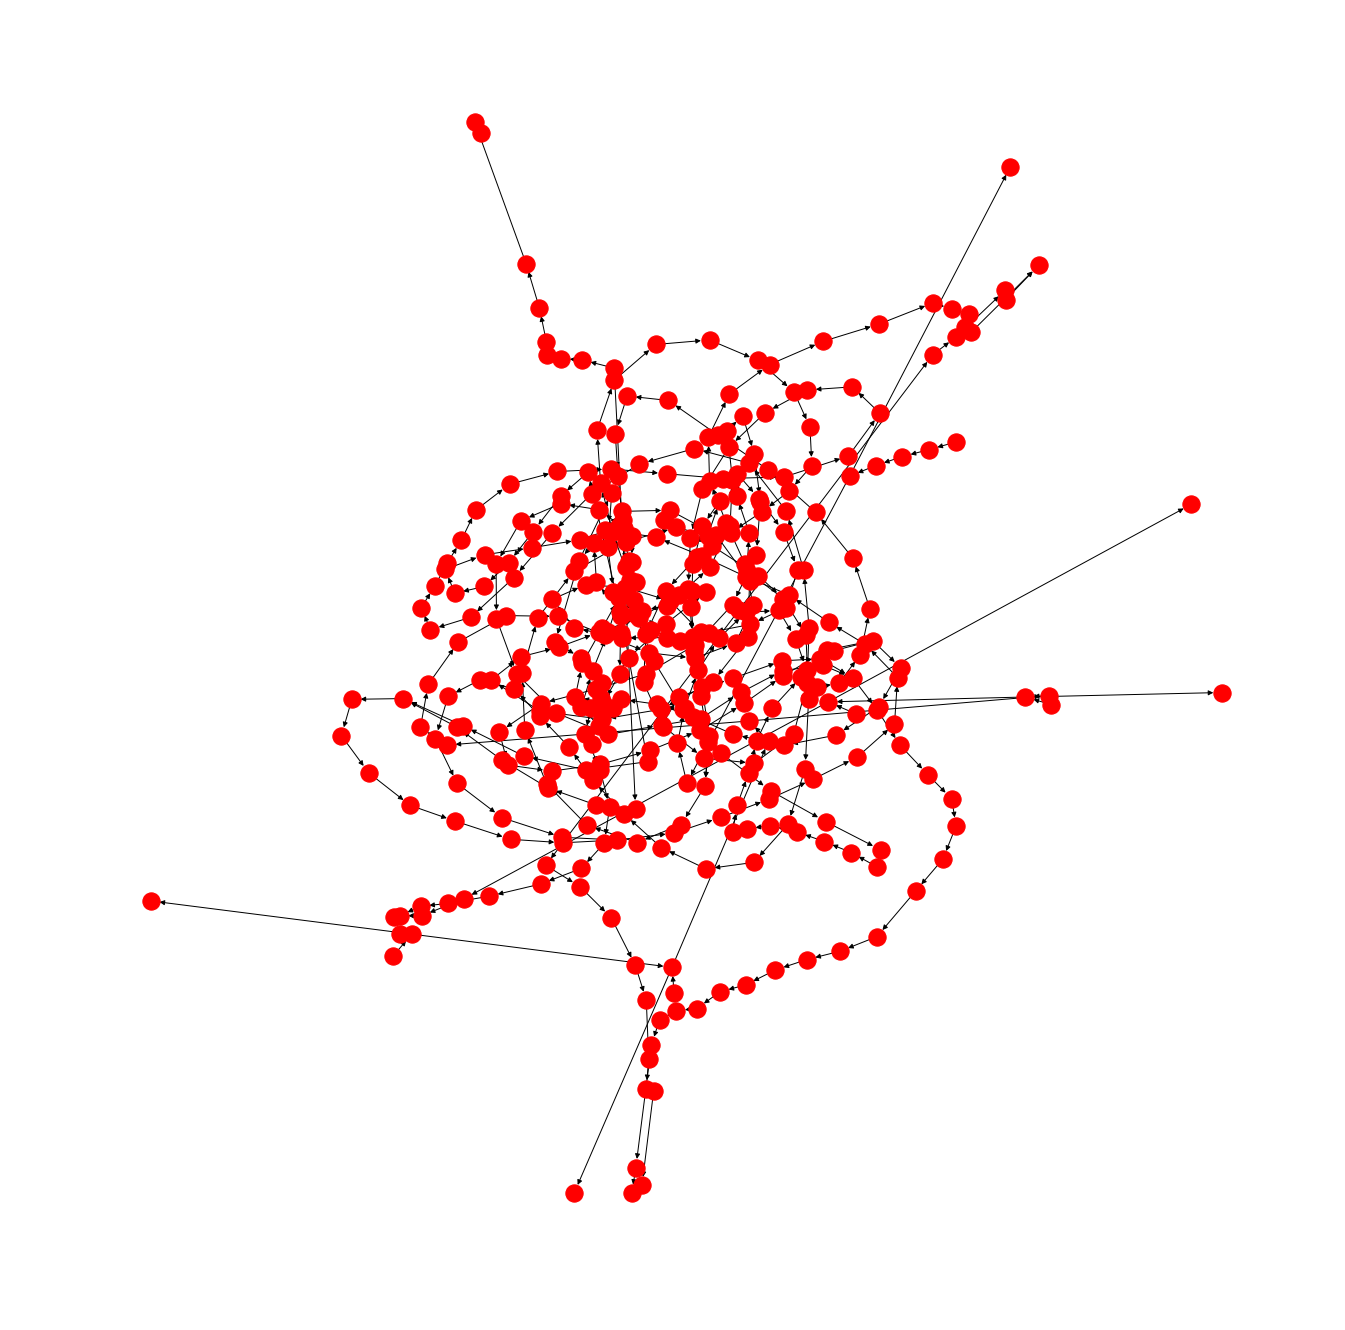

In [2]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

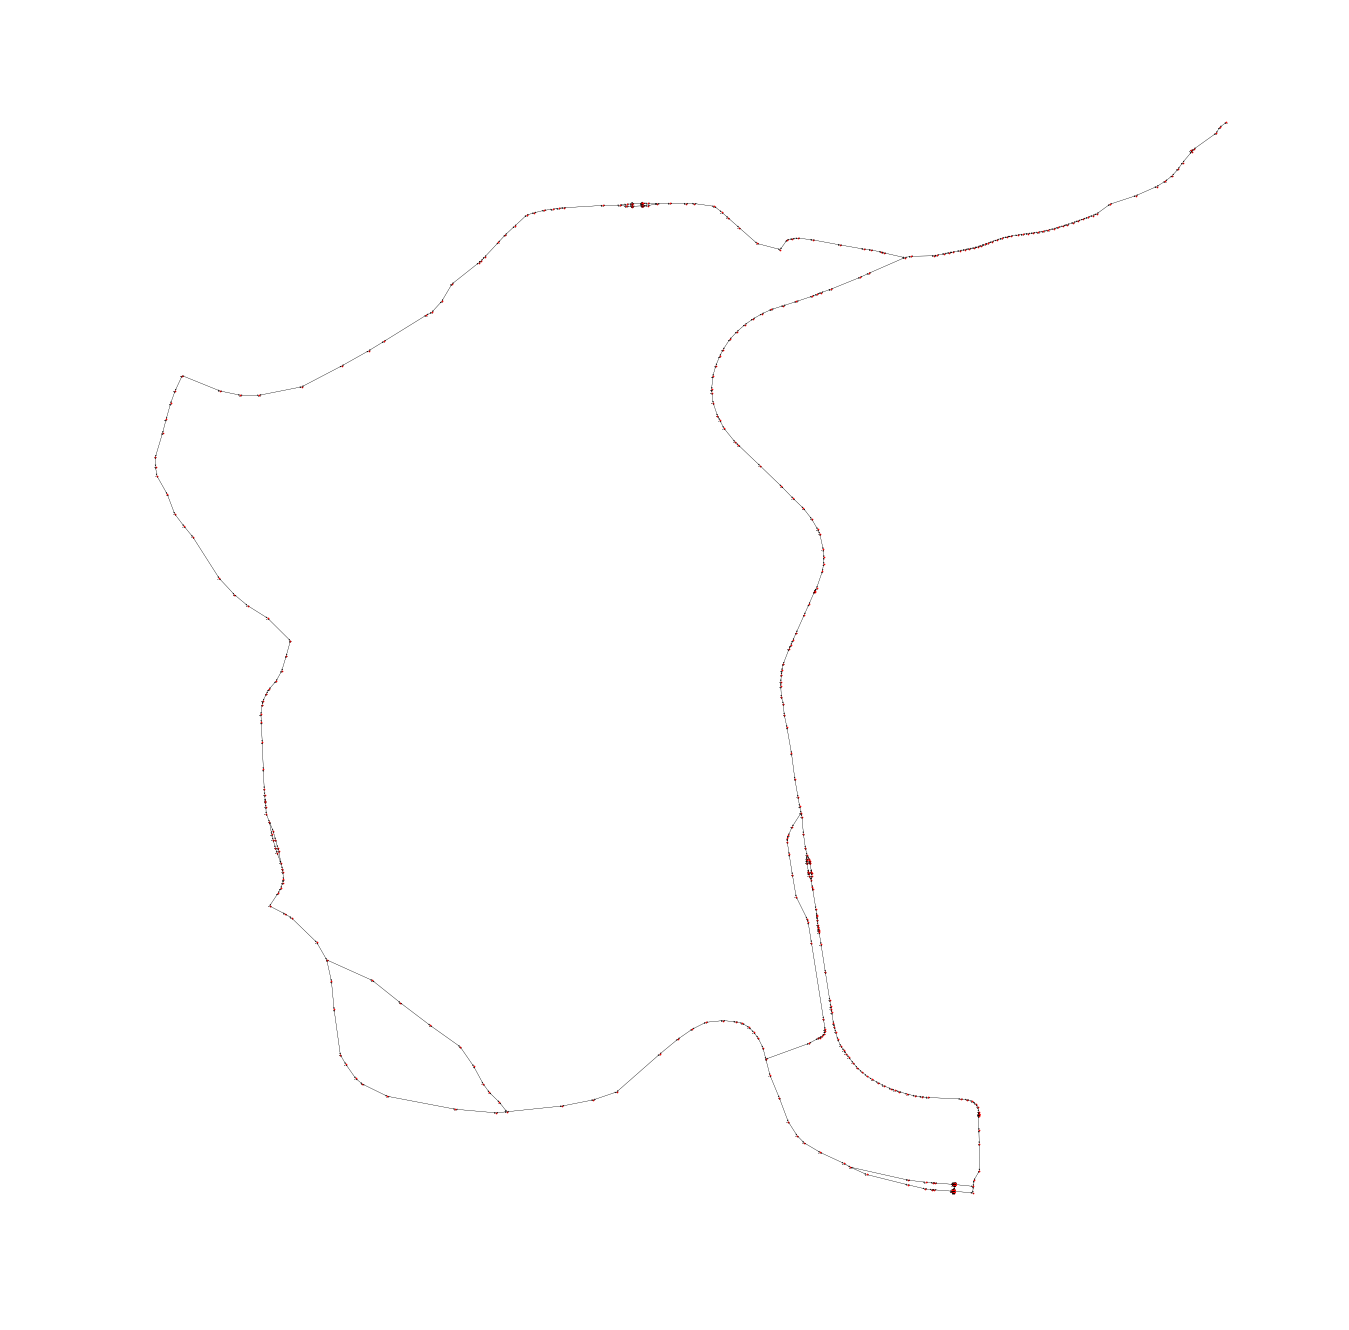

In [3]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                         shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), with_labels=True, node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Create vessels
Vessel without graph, but with shortest path.

In [4]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### Define paths

In [5]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_1 = nx.dijkstra_path(FG, random_1, random_2)
print(path_1)

[314, 79, 80, 81, 47, 43, 41, 42, 66, 67, 68, 69, 70, 106, 107, 108, 349, 350, 153, 53, 54, 55, 324, 243, 113, 114, 115, 285, 286, 238, 29, 30, 31, 48, 49, 351, 320, 124, 125, 126, 26, 27, 28, 135, 310, 190, 191, 192, 121, 122, 123, 330, 331, 127, 128]


In [6]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_2 = nx.dijkstra_path(FG, random_1, random_2)
print(path_2)

[301, 300, 405, 78, 77, 76, 339, 58, 57, 56, 381, 201, 200, 199, 406, 327, 326, 215, 214, 213, 362, 204, 203, 202, 408, 407, 299, 298, 297, 293, 292, 291, 355, 177, 176, 175, 212, 211, 8, 7, 6, 375, 5, 4, 3, 22, 21, 189, 361, 360, 149, 148, 147, 151, 188, 187, 385, 384, 142, 93, 92, 91, 186, 185, 283, 284, 359, 18]


In [7]:
paths = [path_1, path_2]

### Run simulation

In [8]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [9]:
for path in enumerate(paths):
    # Start simpy environment
    env = simpy.Environment()
    
    # Add graph to environment
    env.FG = FG
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]

    # Start the simulation
    env.process(start(env, vessel))
    env.run()

    print("Simulation of path {} took {} seconds".format(path[0] + 1, int(env.now)))

Simulation of path 1 took 5717660 seconds
Simulation of path 2 took 50435 seconds


### Testing
With v = 1 the distance of a path should be equal to the simulation time.

If simulation time == distance of path, test succeeds.

In [11]:
for geo in vessel.log["Geometry"]:
    print(geo.x, geo.y)

0.0 0.0
4.2906107 51.3462133
4.2906107 51.3462133
4.2903083 51.3462317
4.2903083 51.3462317
4.2898595 51.3462538
4.2898595 51.3462538
4.2898218 51.3459962
4.2898218 51.3459962
4.2982523 51.3453443
4.2982523 51.3453443
4.2984587 51.3472541
4.2984587 51.3472541
4.3007857 51.3503648
4.3007857 51.3503648
4.3006953 51.3591295
4.3006953 51.3591295
4.3005744 51.3634031
4.3005744 51.3634031
4.3004438 51.3680209
4.3004438 51.3680209
4.3004692 51.3683994
4.3004692 51.3683994
4.3004749 51.3684538
4.3004749 51.3684538
4.3004793 51.3684987
4.3004793 51.3684987
4.3004834 51.3685427
4.3004834 51.3685427
4.3004887 51.3685818
4.3004887 51.3685818
4.3005039 51.3686735
4.3005039 51.3686735
4.3005054 51.3693936
4.3005054 51.3693936
4.3000304 51.3709503
4.3000304 51.3709503
4.299215 51.371888
4.299215 51.371888
4.2979276 51.3726917
4.2979276 51.3726917
4.2956788 51.3732757
4.2956788 51.3732757
4.2930352 51.3734686
4.2930352 51.3734686
4.279474 51.3739776
4.279474 51.3739776
4.276942 51.3741919
4.276942 51.

In [12]:
vessel.log["Timestamp"]

[0,
 5704969.331808573,
 5704969.331808573,
 5704990.500426428,
 5704990.500426428,
 5705021.866600482,
 5705021.866600482,
 5705050.645983444,
 5705050.645983444,
 5705642.499953818,
 5705642.499953818,
 5705855.460660964,
 5705855.460660964,
 5706237.63273445,
 5706237.63273445,
 5707212.770302184,
 5707212.770302184,
 5707688.3050274765,
 5707688.3050274765,
 5708202.140123398,
 5708202.140123398,
 5708244.287396411,
 5708244.287396411,
 5708250.352689279,
 5708250.352689279,
 5708255.357442317,
 5708255.357442317,
 5708260.260996409,
 5708260.260996409,
 5708264.626709761,
 5708264.626709761,
 5708274.883590316,
 5708274.883590316,
 5708354.99862435,
 5708354.99862435,
 5708531.320324181,
 5708531.320324181,
 5708650.095794818,
 5708650.095794818,
 5708776.712785082,
 5708776.712785082,
 5708946.248666767,
 5708946.248666767,
 5709131.576688137,
 5709131.576688137,
 5710077.569994427,
 5710077.569994427,
 5710255.482228839,
 5710255.482228839,
 5710455.412678863,
 5710455.412678863

In [13]:
wgs84 = pyproj.Geod(ellps='WGS84')
distance_path_1 = 0
distance_path_2 = 0

for node in enumerate(path_1):
    orig = nx.get_node_attributes(FG, "geometry")[path_1[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_1[node[0] + 1]]

    distance_path_1 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_1):
                break

for node in enumerate(path_2):
    orig = nx.get_node_attributes(FG, "geometry")[path_2[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_2[node[0] + 1]]

    distance_path_2 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_2):
                break

In [14]:
distance_path_1, distance_path_2

(12665, 26099)